In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

Using TensorFlow backend.


In [2]:
df = read_csv('dataset/irondata.csv')

In [3]:
df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y')

In [4]:
df=df.sort_values('date')
df['Month']=df['date'].dt.month
df['price_lag']=df['price'].shift(1)
df['price_diff']=df['price_lag'].diff(periods=1)
df=df.set_index('date')
df['rolling_mean_price']=df['price_lag'].rolling(2, min_periods=1).sum()
df=df.dropna()
df.head()

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
1990-03-31,14.05,3,14.05,0.0,28.1
1990-04-30,14.05,4,14.05,0.0,28.1
1990-05-31,14.05,5,14.05,0.0,28.1
1990-06-30,14.05,6,14.05,0.0,28.1
1990-07-31,14.05,7,14.05,0.0,28.1


In [5]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['price'] = min_max_scaler.fit_transform(df.price.values.reshape(-1,1))
    df['Month'] = min_max_scaler.fit_transform(df.Month.values.reshape(-1,1))
    df['price_lag'] = min_max_scaler.fit_transform(df.price_lag.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [6]:
# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
1990-03-31,0.014795,0.181818,0.014795,0.0,0.01512
1990-04-30,0.014795,0.272727,0.014795,0.0,0.01512
1990-05-31,0.014795,0.363636,0.014795,0.0,0.01512
1990-06-30,0.014795,0.454545,0.014795,0.0,0.01512
1990-07-31,0.014795,0.545455,0.014795,0.0,0.01512


In [7]:
len(df_stock_norm)

346

In [8]:
df_stock_norm.head()

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
1990-03-31,0.014795,0.181818,0.014795,0.0,0.01512
1990-04-30,0.014795,0.272727,0.014795,0.0,0.01512
1990-05-31,0.014795,0.363636,0.014795,0.0,0.01512
1990-06-30,0.014795,0.454545,0.014795,0.0,0.01512
1990-07-31,0.014795,0.545455,0.014795,0.0,0.01512


In [9]:
data_raw = df_stock_norm.as_matrix()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [10]:
data_raw.shape

(346, 5)

In [11]:
test_set_size = int(np.round(test_set_size_percentage/100*data_raw.shape[0]))
train_set_size = data_raw.shape[0] - (test_set_size)

In [12]:
x_train = data_raw[:train_set_size,1:] #without price column
y_train = data_raw[:train_set_size,0] #with price column

x_test = data_raw[train_set_size:,1:]
y_test = data_raw[train_set_size:,0]

In [13]:
# data_raw
# data_raw[:,1:].shape
# data_raw[:,0].shape

In [19]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (277, 4, 1)
y_train.shape =  (277,)
x_test.shape =  (69, 4, 1)
y_test.shape =  (69,)


In [20]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

In [21]:
#Build the model
# Predict every 20th time step
model = Sequential()
model.add(LSTM(256,input_shape=(1,4))) # 4 feature with one time stamps
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 283,777
Trainable params: 283,777
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=2,validation_split=0.1,shuffle=False)


Train on 249 samples, validate on 28 samples
Epoch 1/2
249/249 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.0482 - val_loss: 0.4808 - val_accuracy: 0.0000e+00
Epoch 2/2
249/249 [==============================] - 0s 256us/step - loss: 0.0131 - accuracy: 0.0482 - val_loss: 0.2442 - val_accuracy: 0.0357


In [24]:
pred_price = model.predict(x_test,batch_size=1,verbose=1)

69/69 [==============================] - 0s 2ms/step


In [25]:
pred_price

array([[0.36632442],
       [0.08996782],
       [0.3398383 ],
       [0.2503933 ],
       [0.56950265],
       [0.49295717],
       [0.09553978],
       [0.08145753],
       [0.26831993],
       [0.07387279],
       [0.21480627],
       [0.19193897],
       [0.2568197 ],
       [0.20470402],
       [0.349193  ],
       [0.21230404],
       [0.23237452],
       [0.07538025],
       [0.25731754],
       [0.09778993],
       [0.18992527],
       [0.16016276],
       [0.07887881],
       [0.14789201],
       [0.15586922],
       [0.1662816 ],
       [0.39809796],
       [0.13246651],
       [0.25393543],
       [0.28806672],
       [0.06269474],
       [0.09703715],
       [0.17624222],
       [0.17008254],
       [0.1116727 ],
       [0.23268853],
       [0.45256677],
       [0.25039956],
       [0.142399  ],
       [0.10355225],
       [0.27797997],
       [0.22657564],
       [0.09481101],
       [0.13020435],
       [0.6493409 ],
       [0.2781065 ],
       [0.12799048],
       [0.393

In [26]:
def denormalize(df, normalized_value): 
    df = df['price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, pred_price)
newy_test = denormalize(df, y_test)

In [27]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.03621 MSE (0.19 RMSE)
Test Score: 0.05834 MSE (0.24 RMSE)


(0.036211749209286076, 0.05834169664244721)

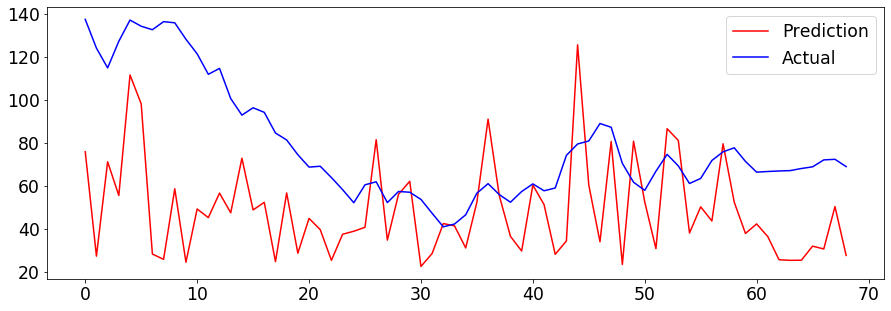

In [28]:
plt.figure(figsize=(15, 5));
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

In [29]:
import pandas as pd
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(newy_test)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

In [30]:
act_pred

,Predicted,Actual
0,75.824196,137.39
1,27.260044,124.01
2,71.169785,114.82
3,55.451618,127.19
4,111.528702,137.06
...,...,...
64,25.365967,68.02
65,31.916157,68.80
66,30.587006,72.02
67,50.309856,72.30
